In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler


In [2]:
## 1. 读取数据
training_set = pd.read_csv('airline-passengers.csv')
training_set.head(2)

,Month,Passengers
0,1949-01,112
1,1949-02,118


In [47]:
training_set.shape

(144, 2)

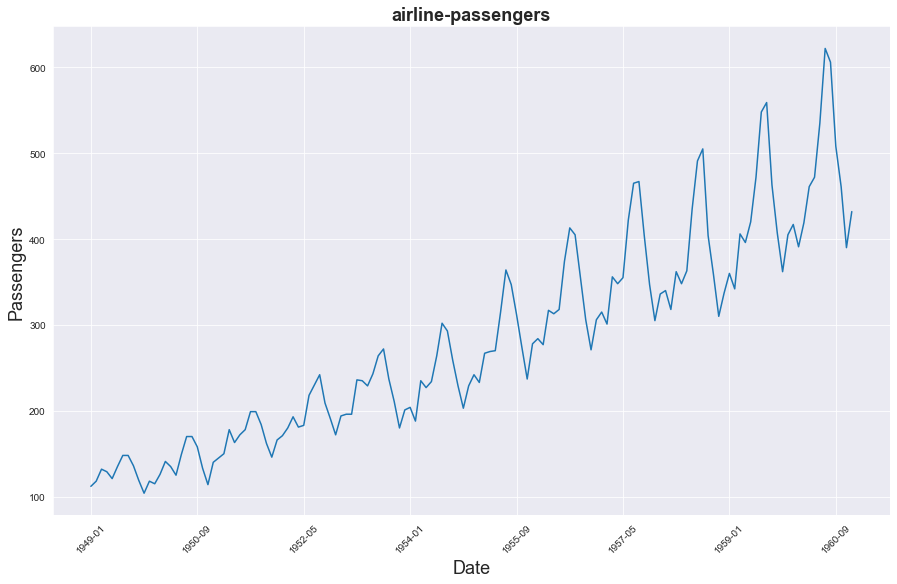

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.figure(figsize = (15,9))
plt.plot(training_set[['Passengers']])

plt.xticks(range(0,training_set.shape[0],20), training_set['Month'].loc[::20], rotation=45)  # x 轴 

plt.title("airline-passengers",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Passengers',fontsize=18)
plt.show()

## 2. 数据的归一化 划分数据集

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler_data = scaler.fit_transform(training_set['Passengers'].values.reshape(-1,1))

In [5]:
scaler_data.shape

(144, 1)

In [6]:
scaler_data[:2]

array([[-0.96911197],
       [-0.94594595]])

## 划分数据集 的方式 放到后面 

In [7]:
from sklearn.model_selection import train_test_split
#data:需要进行分割的数据集
#random_state:设置随机种子，保证每次运行生成相同的随机数
#test_size:将数据分割成训练集的比例
train_set, test_set = train_test_split(scaler_data, test_size=0.2, random_state=42)
print(len(train_set),len(test_set))

115 29


In [8]:
# scaler_data   是一个 array 格式，数据范围在 -1 到 +1 

In [9]:
type(scaler_data)

numpy.ndarray

## 3.   数据集制作

In [11]:
from torch.utils.data import Dataset, DataLoader,random_split
class MyDataset(Dataset): 
    # 传入  数据，
    def __init__(self, data_source,seq_length):
        self.data_source = data_source  # 输入的数据
        self.seq = seq_length       # 数据的尺度， 
         
    
    # 根据索引 返回 x 和 y  也叫 输入特征 和对应的标签 
    # 初步逻辑是 使用前三个数据，预测第四个数据 
    def __getitem__(self, index): 
        
        x=self.data_source[index : index + self.seq ] 
        y= self.data_source[ index + self.seq ] 
        
        x_Tensor = torch.from_numpy(x).type(torch.Tensor)
        y_Tensor = torch.from_numpy(x).type(torch.Tensor)
        return ( x_Tensor, y_Tensor  )
    
    # 返回数据集的长度
    def __len__(self):  
        return (len(self.data_source) - self.seq ) 
         


### 加载数据

In [12]:
# Define dataset 
my_dataset = MyDataset(data_source=scaler_data ,seq_length=3)


###  测试 读取数据 

In [13]:
    
data_all_loader = DataLoader(dataset=my_dataset, # 传递数据集
                          batch_size=5 , #一个小批量容量是多少
                          shuffle=True , # 数据集顺序是否要打乱，一般是要的。测试数据集一般没必要
                          num_workers=0) # 需要几个进程来一次性读取这个小批量数据



In [14]:
len(data_all_loader)

29

## 查看 训练的源数据 

In [15]:
for i , batch   in  enumerate(data_all_loader) :
    print( len(batch ) )
    break

2


In [16]:
batch[0].shape

torch.Size([5, 3, 1])

In [17]:
batch[0].shape  # x 

torch.Size([5, 3, 1])

In [18]:
batch[1].shape   # y 

torch.Size([5, 3, 1])

## 划分数据集 和测试集 

In [19]:
data_length = len(my_dataset)
data_length

141

In [20]:
# Split dataset into training and validation / 验证机
lengths = [int(data_length - 20), 20]
train_data, test_data = random_split(my_dataset, lengths)
print( len(train_data)  , len(test_data)  )

121 20


# 使用dataloader 加载数据集 

In [21]:
batch_size=5
train_loader = DataLoader(
        train_data, batch_size=batch_size, shuffle=True, num_workers=0
    )
test_loader = DataLoader(
    test_data, batch_size=batch_size, shuffle=True, num_workers=0
    )

# 构建模型 LSTM

In [22]:

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        #out = self.fc(out[:, -1, :]) 
        out = self.fc(out) 
        return out

# batch_first 设置 为 TRUE  安装  (batch, seq, feature)  x输入 按照这样的顺序 

## 网络 模型的 参数 

In [23]:
input_dim = 1    # 输入的 x 的纬度 ( 特征项 )  输入数据的特征维数 
hidden_dim = 32    #  隐藏层的大小   LSTM中隐层的维度 
num_layers = 2   #   循环神经网络的层数 
output_dim = 1  #  输出的纬度 
num_epochs = 100  # 训练的次数 

In [24]:
# 1. 模型的 实例化 
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
#  2. 设置损失函数 
criterion = torch.nn.MSELoss()
# 3. 设置 学习率
learning_rate = 0.01
# 4. 设置 优化器 
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)


###  训练模型

In [25]:
## 调整 数据格式 
for batch_index, (batch_x_train, batch_y_train) in enumerate(train_loader):
    print(type(batch_x_train))
    break

<class 'torch.Tensor'>


In [26]:

import time

hist = np.zeros(num_epochs)
start_time = time.time()

for epoch in range(num_epochs):
    for batch_index, (batch_x_train, batch_y_train) in enumerate(train_loader):
         #  已经 是 tensor 格式 
        y_train_pred = model(batch_x_train)
        #print( batch_y_train.shape , y_train_pred.shape)  # torch.Size([5, 3, 1]) torch.Size([5, 3, 1])
        loss = criterion(y_train_pred, batch_y_train)
       # print("Epoch ", t, "MSE: ", loss.item())
        hist[ epoch ] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
 
        
    if epoch % 50 == 0:
        print('epoch {}, loss {}'.format(epoch, loss.item()))
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

epoch 0, loss 0.03760955110192299
epoch 50, loss 1.4799855989622301e-06
Training time: 5.236091613769531


# 5. 模型结果可视化

In [27]:
##  查看

In [28]:
y_train_pred.detach()

tensor([[[-0.7213],
         [-0.6419],
         [-0.6439]]])

In [29]:
y_train_pred

tensor([[[-0.7213],
         [-0.6419],
         [-0.6439]]], grad_fn=<AddBackward0>)

In [30]:
y_train_pred.shape

torch.Size([1, 3, 1])

In [31]:
batch_y_train.shape

torch.Size([1, 3, 1])

## 对预测数据 进行可视化 查看 

In [32]:
model.eval()

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [33]:
## 使用测试集的数据 
test_data

In [34]:
y_pred=[]
y_test=[]
for batch_index, (batch_x_test, batch_y_test) in enumerate(test_loader):
         #  已经 是 tensor 格式 
        
    y_test_pred = model(batch_x_test)
    y_pred.append(y_test_pred)
    y_test.append(batch_y_test)


In [35]:
len( y_pred ) , len( y_test )

(4, 4)

In [36]:
y_pred[0].shape

torch.Size([5, 3, 1])

In [37]:
y_pred[0].detach().numpy().reshape(-1)

array([-0.5946388 , -0.70117646, -0.62502867, -0.7879176 , -0.8687309 ,
       -0.9355925 , -0.36072254, -0.49585485, -0.34749734, -0.49841213,
       -0.5894864 , -0.6996071 ,  0.13100903, -0.08888778, -0.24910365],
      dtype=float32)

In [38]:
#  测试集 预测的 y 结果 
y_p_all=[i.detach().numpy().reshape(-1).tolist()     for i  in y_pred ]
y_p_all_list=sum(y_p_all,[] )
len(y_p_all_list)

60

In [39]:
# 测试集 实际的 y 的值 
y_t_all=[i.detach().numpy().reshape(-1).tolist()     for i  in y_test ]
y_t_all_list=sum(y_t_all,[] )
len(y_t_all_list)

60

##  将 归一化的数据 还原 回去 进行比较 

In [40]:
  #  np.array(y_p_all_list).reshape(-1,1)   

In [41]:
predict = pd.DataFrame(scaler.inverse_transform(      np.array(y_p_all_list).reshape(-1,1)    ))  # 预测值 
original = pd.DataFrame(scaler.inverse_transform(      np.array(y_t_all).reshape(-1,1)         ))  # 真实值

In [43]:
predict.tail()

,0
55,401.325216
56,353.819312
57,311.189895
58,306.612468
59,311.404138


In [44]:
original.tail()

,0
55,407.000001
56,362.000000
57,316.999999
58,313.000001
59,318.000001


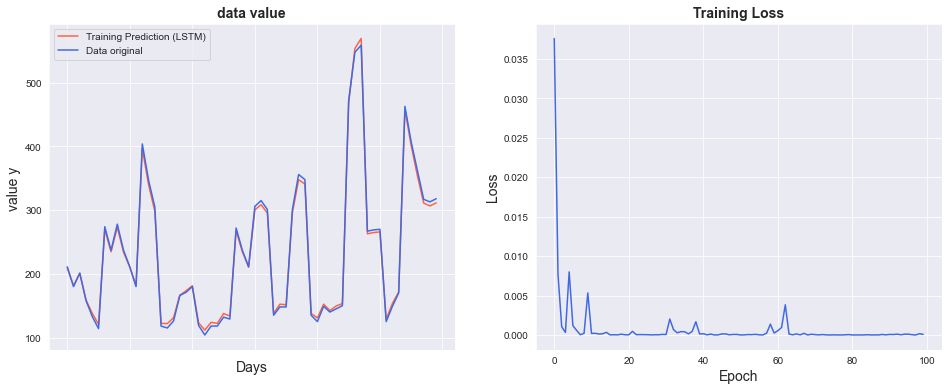

In [46]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax = sns.lineplot(x = original.index, y = original[0], label="Data original", color='royalblue')

ax.set_title('data value', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("value y ", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)
